In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install ta
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.1.0
!pip install --upgrade grpcio

In [0]:
%matplotlib inline
%load_ext tensorboard
# %tensorboard --logdir logs

In [0]:
APP_PATH = "/content/drive/My Drive/Programming/stock_predictions"

import sys
sys.path.append(APP_PATH)


import numpy as np
np.random.seed(123)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.utils import plot_model


from stock_predictions.constants import *
from stock_predictions.plots import *
from stock_predictions.train_test_split import *
from stock_predictions.rnn import *
from stock_predictions.metrics import *
from libs.tech_indicators.tech_indicators import calculate_tech_indicators
from libs.time_series_transformer.pipeline import create_pipeline
from libs.autoencoder.autoencoder import *


## Preparing Datasets

### Preparing Autoencoder Model Dataset


In [0]:
stocks_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
stock_prices_autoenc_train = pd.concat([stocks_prices_train, stocks_prices_val])

In [0]:
num_fetures_count = stocks_prices_train["lag_1"].shape[1] # 27
batch_size = len(stocks_prices_train.index.get_level_values(TICKER_COL).unique())

In [0]:
stocks_autoenc_train = tf.data.Dataset.from_tensor_slices((stock_prices_autoenc_train.values.reshape((stock_prices_autoenc_train.values.shape[0], TIME_STEPS,num_fetures_count)), (stock_prices_autoenc_train.values.reshape((stock_prices_autoenc_train.values.shape[0], TIME_STEPS,num_fetures_count)))))
stocks_autoenc_train = stocks_autoenc_train.batch(batch_size, drop_remainder=True)
stocks_autoenc_val = tf.data.Dataset.from_tensor_slices((stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)), (stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)))))
stocks_autoenc_val = stocks_autoenc_val.batch(batch_size, drop_remainder=True)

In [0]:
stocks_autoenc_train

<BatchDataset shapes: ((2661, 5, 27), (2661, 5, 27)), types: (tf.float64, tf.float64)>

In [0]:
stocks_autoenc_val

<BatchDataset shapes: ((2661, 5, 27), (2661, 5, 27)), types: (tf.float64, tf.float64)>

### Preparing RNN Model Dataset

In [0]:
stocks_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + CATS_TRAIN_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + CATS_VALIDATION_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + CATS_TEST_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
num_fetures_count = stocks_prices_train["lag_1"].shape[1] # 27
batch_size = len(stocks_prices_train.index.get_level_values(TICKER_COL).unique())

In [0]:
stocks_train = tf.data.Dataset.from_tensor_slices(((stocks_prices_train.values.reshape((stocks_prices_train.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_train.values), stocks_targets_train.values))
stocks_train = stocks_train.batch(batch_size)

In [0]:
stocks_train

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

In [0]:
stocks_val = tf.data.Dataset.from_tensor_slices(((stocks_prices_val.values.reshape((stocks_prices_val.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_val.values), stocks_targets_val.values))
stocks_val = stocks_val.batch(batch_size)

In [0]:
stocks_val

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

In [0]:
stocks_test = tf.data.Dataset.from_tensor_slices(((stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_test.values), stocks_targets_test.values))
stocks_test = stocks_test.batch(batch_size)

In [0]:
stocks_test

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

### Preparing RNN Price Direction Model Dataset

In [0]:
def transform_data_to_price_direction_classification(prices, categories, targets):
  targets["price_change"] = targets.groupby(level=0).diff()
  targets["price_direction"] =  (targets["price_change"] >= 0).astype(int)
  date_to_drop = targets.index.get_level_values(1)[0]
  targets.dropna(inplace=True)
  targets = pd.DataFrame(targets["price_direction"])

  prices = prices[prices.index.get_level_values(1) != date_to_drop]
  categories = categories[categories.index.get_level_values(1) != date_to_drop]

  return prices, categories, targets

In [0]:
stocks_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + CATS_TRAIN_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + CATS_VALIDATION_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + CATS_TEST_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
stocks_prices_train, stocks_cats_train, stocks_targets_train = transform_data_to_price_direction_classification(stocks_prices_train, stocks_cats_train, stocks_targets_train)
stocks_prices_val, stocks_cats_val, stocks_targets_val = transform_data_to_price_direction_classification(stocks_prices_val, stocks_cats_val, stocks_targets_val)
stocks_prices_test, stocks_cats_test, stocks_targets_test = transform_data_to_price_direction_classification(stocks_prices_test, stocks_cats_test, stocks_targets_test)

In [0]:
num_fetures_count = stocks_prices_train["lag_1"].shape[1] # 27
batch_size = len(stocks_prices_train.index.get_level_values(TICKER_COL).unique())

In [0]:
stocks_train = tf.data.Dataset.from_tensor_slices(((stocks_prices_train.values.reshape((stocks_prices_train.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_train.values), stocks_targets_train.values))
stocks_train = stocks_train.batch(batch_size)

In [0]:
stocks_train

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.int64)>

In [0]:
stocks_val = tf.data.Dataset.from_tensor_slices(((stocks_prices_val.values.reshape((stocks_prices_val.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_val.values), stocks_targets_val.values))
stocks_val = stocks_val.batch(batch_size)

In [0]:
stocks_val

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.int64)>

In [0]:
stocks_test = tf.data.Dataset.from_tensor_slices(((stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_test.values), stocks_targets_test.values))
stocks_test = stocks_test.batch(batch_size)

In [0]:
stocks_test

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.int64)>

### Preparing Single Stock Stacked LSTM Dataset



In [0]:
single_stock_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

single_stock_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

single_stock_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
stock_ticker = "AAPL"

In [0]:
single_stock_prices_train = single_stock_prices_train[single_stock_prices_train.index.get_level_values(0) == stock_ticker]
single_stock_targets_train = single_stock_targets_train[single_stock_targets_train.index.get_level_values(0) == stock_ticker]

single_stock_prices_val = single_stock_prices_val[single_stock_prices_val.index.get_level_values(0) == stock_ticker]
single_stock_targets_val = single_stock_targets_val[single_stock_targets_val.index.get_level_values(0) == stock_ticker]

single_stock_prices_test = single_stock_prices_test[single_stock_prices_test.index.get_level_values(0) == stock_ticker]
single_stock_targets_test = single_stock_targets_test[single_stock_targets_test.index.get_level_values(0) == stock_ticker]

In [0]:
num_fetures_count = single_stock_prices_train["lag_1"].shape[1] # 27
single_stock_batch_size = 1

In [0]:
single_stock_train = tf.data.Dataset.from_tensor_slices((single_stock_prices_train.values.reshape(single_stock_prices_train.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_train.values))
single_stock_train = single_stock_train.batch(single_stock_batch_size)

In [8]:
single_stock_train

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

In [0]:
single_stock_val = tf.data.Dataset.from_tensor_slices((single_stock_prices_val.values.reshape(single_stock_prices_val.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_val.values))
single_stock_val = single_stock_val.batch(single_stock_batch_size)

In [10]:
single_stock_val

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

In [0]:
single_stock_test = tf.data.Dataset.from_tensor_slices((single_stock_prices_test.values.reshape(single_stock_prices_test.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_test.values))
single_stock_test = single_stock_test.batch(single_stock_batch_size)

In [12]:
single_stock_test

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

## Autoencoder

### Training Autoencoder Model

In [0]:
autoencoder = load_model(AUTOENC_SAVE_PATH)
autoenc_hist = pickle.load(open(AUTOENC_HISTORY_PATH, "rb"))
autoenc_tbc = TensorBoard(log_dir=AUTOENC_TBC_PATH)

steps_per_epoch=int(len(stock_prices_autoenc_train) / batch_size)

In [0]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
# autoencoder, autoenc_hist = training_stateful_rnn(autoencoder, stocks_autoenc_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=stocks_autoenc_val, callbacks=[autoenc_tbc])

In [0]:
autoencoder, autoenc_hist = training_stateful_rnn(autoencoder, stocks_autoenc_train, init_epoch=800, epochs=400, steps_per_epoch=steps_per_epoch, val_data=stocks_autoenc_val, history=autoenc_hist, callbacks=[autoenc_tbc])

Train for 462 steps, validate for 5 steps
Epoch 801/801
462/462 [==============================] - 39s 85ms/step - loss: 1.0783e-05 - root_mean_squared_error: 0.0033 - val_loss: 1.4318e-05 - val_root_mean_squared_error: 0.0038
Train for 462 steps, validate for 5 steps
Epoch 802/802
462/462 [==============================] - 18s 39ms/step - loss: 1.0432e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.3909e-05 - val_root_mean_squared_error: 0.0037
Train for 462 steps, validate for 5 steps
Epoch 803/803
462/462 [==============================] - 18s 39ms/step - loss: 1.0413e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.4040e-05 - val_root_mean_squared_error: 0.0037
Train for 462 steps, validate for 5 steps
Epoch 804/804
462/462 [==============================] - 18s 39ms/step - loss: 1.0388e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.4118e-05 - val_root_mean_squared_error: 0.0038
Train for 462 steps, validate for 5 steps
Epoch 805/805
462/462 [===========================

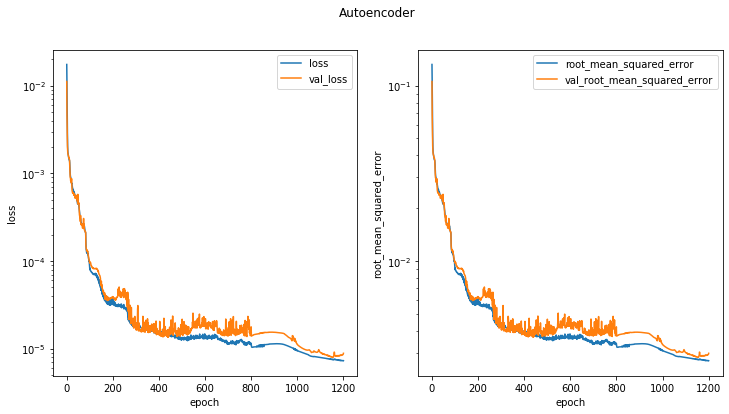

In [0]:
plot_model_history(autoenc_hist, fig_title="Autoencoder", log=True)

In [0]:
autoencoder.save(AUTOENC_SAVE_PATH, save_format="h5")
pickle.dump(autoenc_hist, open(AUTOENC_HISTORY_PATH, "wb"))

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/num_autoenc/tbc/'

Saving encoder model.

In [0]:
encoder_inputs = autoencoder.input
encoder_outputs = autoencoder.get_layer("enc_repres_layer").output
encoder = Model(inputs=encoder_inputs, outputs=encoder_outputs, name="lstm_encoder")
encoder.trainable = False

In [0]:
encoder.summary()

Model: "lstm_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(2661, 5, 27)]           0         
_________________________________________________________________
enc_layer_1 (LSTM)           (2661, 5, 64)             23552     
_________________________________________________________________
enc_layer_2 (LSTM)           (2661, 5, 32)             12416     
_________________________________________________________________
enc_repres_layer (LSTM)      (2661, 5, 8)              1312      
Total params: 37,280
Trainable params: 0
Non-trainable params: 37,280
_________________________________________________________________


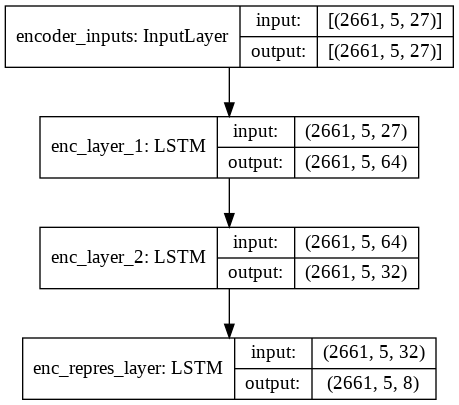

In [0]:
encoder_graph = plot_model(encoder, show_shapes=True, expand_nested=True)
encoder_graph

In [0]:
encoder.save(ENCODER_SAVE_PATH, save_format="h5")

## LSTM With Encoder

### Transfering Encoder Weights

In [0]:
encoder = load_model(ENCODER_SAVE_PATH)

In [0]:
stacked_lstm = load_model(STACKED_LSTM_SAVE_PATH)

In [0]:
stacked_lstm.get_layer("enc_layer_1").set_weights(encoder.get_layer("enc_layer_1").get_weights())
stacked_lstm.get_layer("enc_layer_2").set_weights(encoder.get_layer("enc_layer_2").get_weights())
stacked_lstm.get_layer("enc_repres_layer").set_weights(encoder.get_layer("enc_repres_layer").get_weights())

In [0]:
stacked_lstm.save(STACKED_LSTM_SAVE_PATH, save_format="h5")

### Training Stacked LSTM Model

In [0]:
stacked_lstm = load_model(STACKED_LSTM_SAVE_PATH)
stacked_lstm_hist = pickle.load(open(STACKED_LSTM_HISTORY_PATH, "rb"))
stacked_lstm_tbc = TensorBoard(log_dir=STACKED_LSTM_TBC_PATH)

steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
stacked_lstm.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
# stacked_lstm, stacked_lstm_hist = training_stateful_rnn(stacked_lstm, stocks_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[stacked_lstm_tbc])

In [0]:
stacked_lstm, stacked_lstm_hist = training_stateful_rnn(stacked_lstm, stocks_train, init_epoch=300, epochs=500, steps_per_epoch=steps_per_epoch, val_data=stocks_val, history=stacked_lstm_hist, callbacks=[stacked_lstm_tbc])

Train for 457 steps, validate for 5 steps
Epoch 301/301
457/457 [==============================] - 51s 112ms/step - loss: 3.4697e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.6777e-04 - val_root_mean_squared_error: 0.0164
Train for 457 steps, validate for 5 steps
Epoch 302/302
457/457 [==============================] - 44s 97ms/step - loss: 7.7178e-04 - root_mean_squared_error: 0.0278 - val_loss: 8.8289e-04 - val_root_mean_squared_error: 0.0297
Train for 457 steps, validate for 5 steps
Epoch 303/303
457/457 [==============================] - 46s 100ms/step - loss: 9.3876e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Train for 457 steps, validate for 5 steps
Epoch 304/304
457/457 [==============================] - 44s 97ms/step - loss: 6.1683e-04 - root_mean_squared_error: 0.0248 - val_loss: 4.7361e-04 - val_root_mean_squared_error: 0.0218
Train for 457 steps, validate for 5 steps
Epoch 305/305
457/457 [=============================

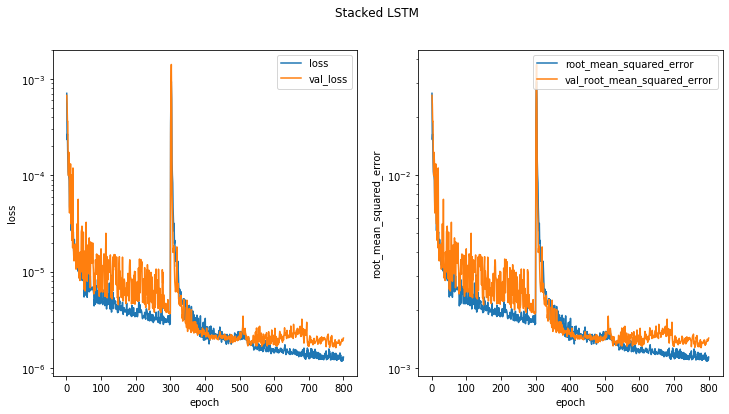

In [0]:
plot_model_history(stacked_lstm_hist, fig_title="Stacked LSTM", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
stacked_lstm_metrics = calculate_model_metrics(stacked_lstm, stacked_lstm_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler)

In [0]:
stacked_lstm_metrics

,stacked_lstm
train_epochs,800.00000
train_mse,0.00000
train_rmse,0.00114
train_inv_scale_rmse,2.84075
train_price_direct_accuracy,0.46926
val_mse,0.00000
val_rmse,0.00143
val_inv_scale_rmse,3.07870
val_price_direct_accuracy,0.38172
test_inv_scale_rmse,3.11825


In [0]:
stacked_lstm.save(STACKED_LSTM_SAVE_PATH, save_format="h5")
pickle.dump(stacked_lstm_hist, open(STACKED_LSTM_HISTORY_PATH, "wb"))
stacked_lstm_metrics.to_csv(STACKED_LSTM_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/stacked_lstm/tbc/'

UsageError: Line magic function `%tensorboard` not found.


## LSTM Without Encoder

### Building Model

In [0]:
EMBEDDED_VECTOR_SIZE = 4
categories_in_class = len(stocks_cats_train["sector_enc"].unique()) # 12

TIME_STEPS = 5

In [0]:
num_input = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=batch_size, name="numerical_inputs")
cats_inputs = Input(shape=(1, ), name="categories_inputs")
cats_embeds = Embedding(input_dim=categories_in_class, output_dim=EMBEDDED_VECTOR_SIZE, name="categories_embeddings")(cats_inputs)
repeat_embeds = concatenate(TIME_STEPS*[cats_embeds], axis=1, name="repeat_categories_embeddings")

concat = concatenate([num_input, repeat_embeds], axis=2, name="concatenate_prices_cat_embeddings")



In [0]:
inputs = [num_input, cats_inputs]
embed_model = Model(inputs=inputs, outputs=concat, name="embedding_model")

In [0]:
LSTM_L1_UNITS = 512
LSTM_L2_UNITS = 256
LSTM_L3_UNITS = 128

stacked_lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, return_sequences=True, name="lstm_layer_1")
stacked_lstm_l2 = LSTM(LSTM_L2_UNITS, stateful=True, return_sequences=True, name="lstm_layer_2")
stacked_lstm_l3 = LSTM(LSTM_L3_UNITS, stateful=True, name="lstm_layer_3")
output = Dense(1, name="output")

lstm_l1_outputs = stacked_lstm_l1(embed_model.output)
lstm_l2_outputs = stacked_lstm_l2(lstm_l1_outputs)
lstm_l3_outputs = stacked_lstm_l3(lstm_l2_outputs)
outputs = output(lstm_l3_outputs)

lstm_without_enc = Model(inputs=embed_model.input, outputs=outputs, name="lstm_without_encoder")

In [0]:
lstm_without_enc.summary()

Model: "lstm_without_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categories_inputs (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
categories_embeddings (Embeddin (None, 1, 4)         48          categories_inputs[0][0]          
__________________________________________________________________________________________________
numerical_inputs (InputLayer)   [(2661, 5, 27)]      0                                            
__________________________________________________________________________________________________
repeat_categories_embeddings (C (None, 5, 4)         0           categories_embeddings[0][0]      
                                                                 categories_emb

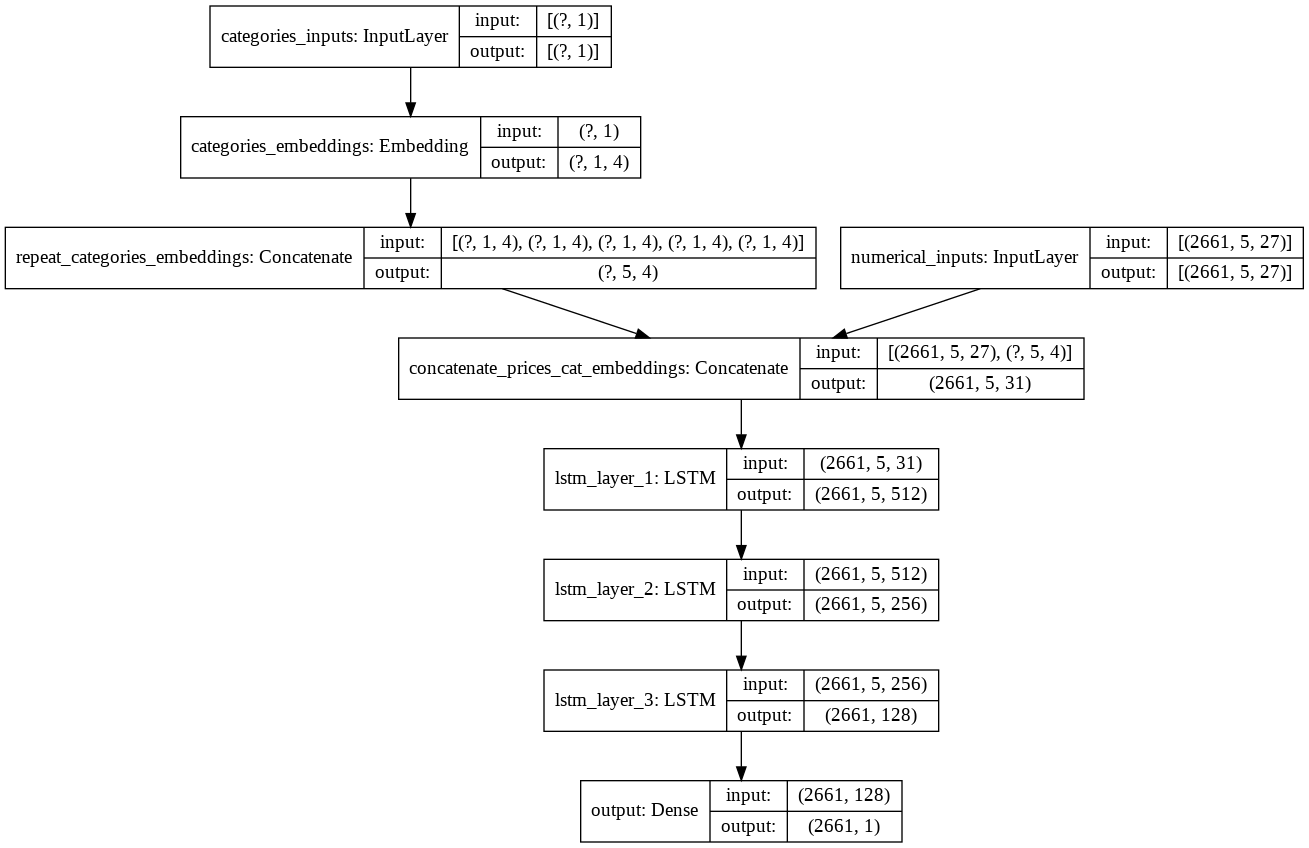

In [0]:
lstm_without_enc_graph = plot_model(lstm_without_enc,show_shapes=True, expand_nested=True)
lstm_without_enc_graph

In [0]:
lstm_without_enc.save(LSTM_WITHOUT_ENC_SAVE_PATH, save_format="h5")

### Training LSTM Without Encoder Model

In [0]:
lstm_without_enc = load_model(LSTM_WITHOUT_ENC_SAVE_PATH)
lstm_without_enc_hist = pickle.load(open(LSTM_WITHOUT_ENC_HISTORY_PATH, "rb"))
lstm_without_enc_tbc = TensorBoard(log_dir=LSTM_WITHOUT_ENC_TBC_PATH)

steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
lstm_without_enc.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
# lstm_without_enc, lstm_without_enc_hist = training_stateful_rnn(lstm_without_enc, stocks_train, init_epoch=0, epochs=400, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[lstm_without_enc_tbc])

In [0]:
lstm_without_enc, lstm_without_enc_hist = training_stateful_rnn(lstm_without_enc, stocks_train, init_epoch=400, epochs=400, steps_per_epoch=steps_per_epoch, val_data=stocks_val, history=lstm_without_enc_hist, callbacks=None)

Train for 457 steps, validate for 5 steps
Epoch 401/401
457/457 [==============================] - 48s 105ms/step - loss: 7.5572e-07 - root_mean_squared_error: 8.6932e-04 - val_loss: 9.5343e-07 - val_root_mean_squared_error: 9.7644e-04
Train for 457 steps, validate for 5 steps
Epoch 402/402
457/457 [==============================] - 44s 97ms/step - loss: 7.5193e-07 - root_mean_squared_error: 8.6714e-04 - val_loss: 9.7529e-07 - val_root_mean_squared_error: 9.8757e-04
Train for 457 steps, validate for 5 steps
Epoch 403/403
457/457 [==============================] - 44s 97ms/step - loss: 7.6007e-07 - root_mean_squared_error: 8.7182e-04 - val_loss: 9.2183e-07 - val_root_mean_squared_error: 9.6012e-04
Train for 457 steps, validate for 5 steps
Epoch 404/404
457/457 [==============================] - 44s 97ms/step - loss: 7.5636e-07 - root_mean_squared_error: 8.6969e-04 - val_loss: 9.1801e-07 - val_root_mean_squared_error: 9.5813e-04
Train for 457 steps, validate for 5 steps
Epoch 405/405
457

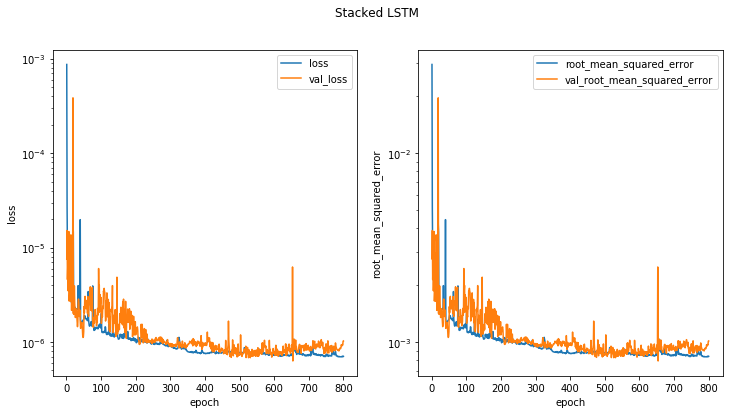

In [0]:
plot_model_history(lstm_without_enc_hist, fig_title="Stacked LSTM", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
lstm_without_enc_metrics = calculate_model_metrics(lstm_without_enc, lstm_without_enc_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler)

In [0]:
# lstm_without_enc_metrics

,lstm_without_encoder
train_epochs,400.00000
train_mse,0.00000
train_rmse,0.00087
train_inv_scale_rmse,1.95399
train_price_direct_accuracy,0.46644
val_mse,0.00000
val_rmse,0.00099
val_inv_scale_rmse,1.91016
val_price_direct_accuracy,0.36509
test_inv_scale_rmse,1.88548


In [0]:
lstm_without_enc_metrics

,lstm_without_encoder
train_epochs,800.00000
train_mse,0.00000
train_rmse,0.00084
train_inv_scale_rmse,1.80637
train_price_direct_accuracy,0.46840
val_mse,0.00000
val_rmse,0.00101
val_inv_scale_rmse,1.90811
val_price_direct_accuracy,0.37326
test_inv_scale_rmse,1.77784


In [0]:
lstm_without_enc.save(LSTM_WITHOUT_ENC_SAVE_PATH, save_format="h5")
pickle.dump(lstm_without_enc_hist, open(LSTM_WITHOUT_ENC_HISTORY_PATH, "wb"))
lstm_without_enc_metrics.to_csv(LSTM_WITHOUT_ENC_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/lstm_without_enc/tbc/'

## Price Direction Prediction Model

### Building Model

In [0]:
EMBEDDED_VECTOR_SIZE = 4
categories_in_class = len(stocks_cats_train["sector_enc"].unique()) # 12

TIME_STEPS = 5

In [0]:
num_input = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=batch_size, name="numerical_inputs")
cats_inputs = Input(shape=(1, ), name="categories_inputs")
cats_embeds = Embedding(input_dim=categories_in_class, output_dim=EMBEDDED_VECTOR_SIZE, name="categories_embeddings")(cats_inputs)
repeat_embeds = concatenate(TIME_STEPS*[cats_embeds], axis=1, name="repeat_categories_embeddings")

concat = concatenate([num_input, repeat_embeds], axis=2, name="concatenate_prices_cat_embeddings")

inputs = [num_input, cats_inputs]
embed_model = Model(inputs=inputs, outputs=concat, name="embedding_model")

LSTM_L1_UNITS = 512
LSTM_L2_UNITS = 256
LSTM_L3_UNITS = 128

stacked_lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, return_sequences=True, name="lstm_layer_1")
stacked_lstm_l2 = LSTM(LSTM_L2_UNITS, stateful=True, return_sequences=True, name="lstm_layer_2")
stacked_lstm_l3 = LSTM(LSTM_L3_UNITS, stateful=True, name="lstm_layer_3")
output = Dense(1, activation="sigmoid", name="output")

lstm_l1_outputs = stacked_lstm_l1(embed_model.output)
lstm_l2_outputs = stacked_lstm_l2(lstm_l1_outputs)
lstm_l3_outputs = stacked_lstm_l3(lstm_l2_outputs)
outputs = output(lstm_l3_outputs)

price_direct = Model(inputs=embed_model.input, outputs=outputs, name="price_direction")

In [0]:
price_direct.summary()

Model: "price_direction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categories_inputs (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
categories_embeddings (Embeddin (None, 1, 4)         48          categories_inputs[0][0]          
__________________________________________________________________________________________________
numerical_inputs (InputLayer)   [(2661, 5, 27)]      0                                            
__________________________________________________________________________________________________
repeat_categories_embeddings (C (None, 5, 4)         0           categories_embeddings[0][0]      
                                                                 categories_embeddin

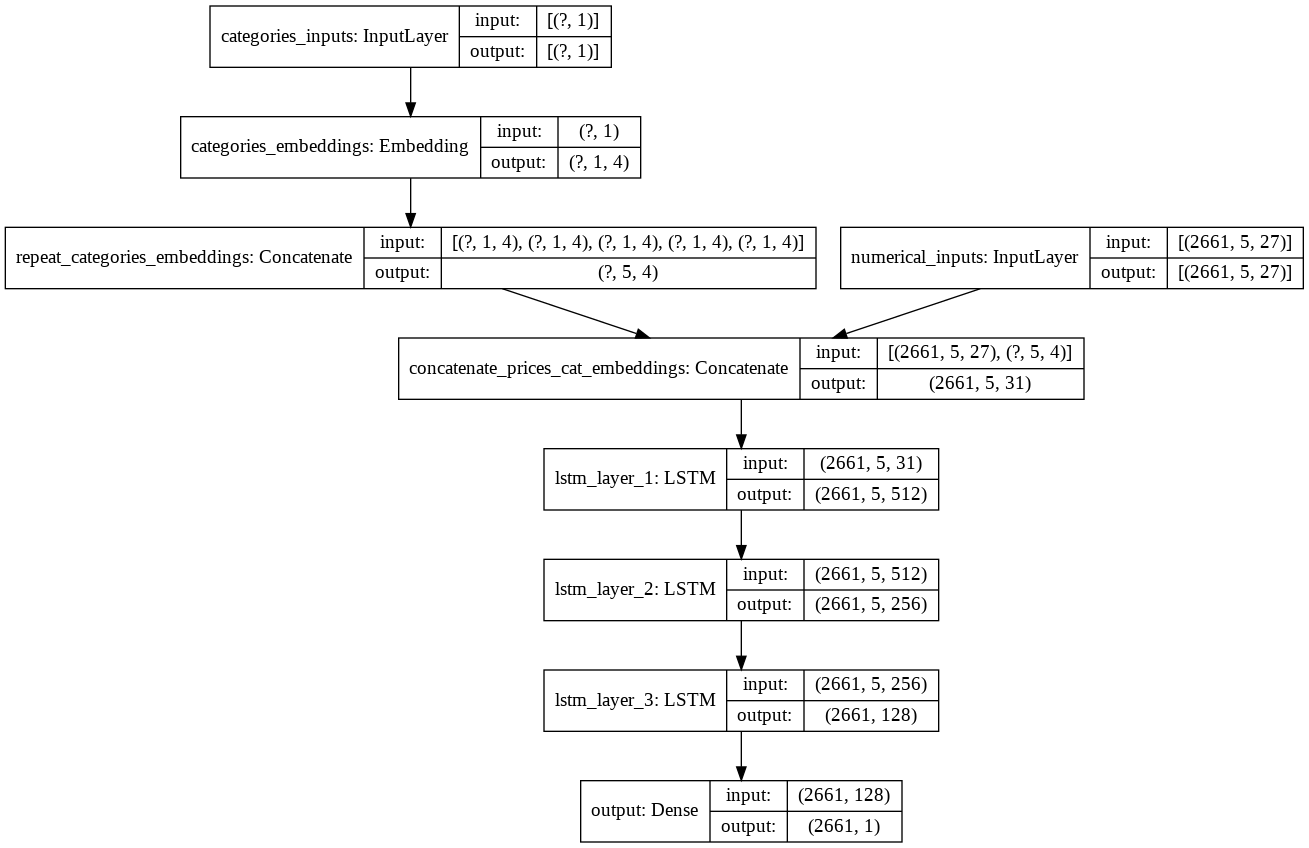

In [0]:
price_direct_graph = plot_model(price_direct, show_shapes=True, expand_nested=True)
price_direct_graph

In [0]:
price_direct.save(PRICE_DIRECTION_SAVE_PATH, save_format="h5")

### Training Model


In [0]:
price_direct = load_model(PRICE_DIRECTION_SAVE_PATH)
# price_direct_hist = pickle.load(open(PRICE_DIRECTION_HISTORY_PATH, "rb"))

steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
price_direct.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.BinaryAccuracy()])

In [0]:
price_direct, price_direct_hist = training_stateful_rnn(price_direct, stocks_train, init_epoch=0, epochs=200, steps_per_epoch=steps_per_epoch, val_data=stocks_val)

Train for 456 steps, validate for 4 steps
456/456 [==============================] - 24s 53ms/step - loss: 0.6929 - binary_accuracy: 0.5331 - val_loss: 0.6796 - val_binary_accuracy: 0.6412
Train for 456 steps, validate for 4 steps
Epoch 2/2
456/456 [==============================] - 21s 46ms/step - loss: 0.6915 - binary_accuracy: 0.5350 - val_loss: 0.6771 - val_binary_accuracy: 0.6412
Train for 456 steps, validate for 4 steps
Epoch 3/3
456/456 [==============================] - 21s 46ms/step - loss: 0.6911 - binary_accuracy: 0.5358 - val_loss: 0.6765 - val_binary_accuracy: 0.6412
Train for 456 steps, validate for 4 steps
Epoch 4/4
456/456 [==============================] - 21s 47ms/step - loss: 0.6910 - binary_accuracy: 0.5358 - val_loss: 0.6762 - val_binary_accuracy: 0.6412
Train for 456 steps, validate for 4 steps
Epoch 5/5
456/456 [==============================] - 21s 46ms/step - loss: 0.6910 - binary_accuracy: 0.5358 - val_loss: 0.6764 - val_binary_accuracy: 0.6412
Train for 456 s

In [0]:
# price_direct, price_direct_hist = training_stateful_rnn(price_direct, stocks_train, init_epoch=200, epochs=200, steps_per_epoch=steps_per_epoch, val_data=stocks_val, history=price_direct_hist)

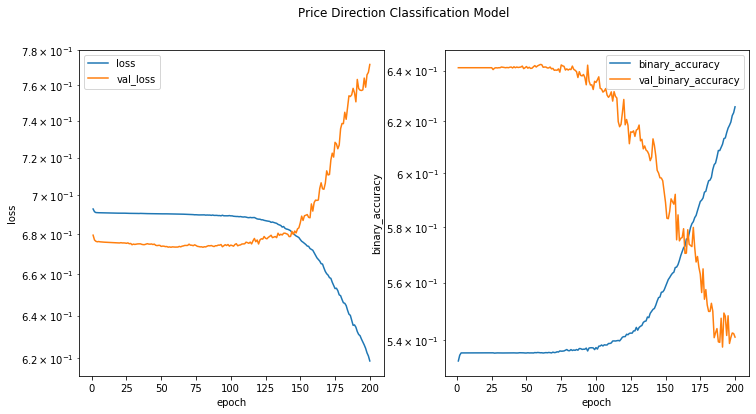

In [0]:
plot_model_history(price_direct_hist, fig_title="Price Direction Classification Model", log=True)

In [0]:
price_direct.save(PRICE_DIRECTION_SAVE_PATH, save_format="h5")
pickle.dump(price_direct_hist, open(PRICE_DIRECTION_HISTORY_PATH, "wb"))

## Single Stock LSTM

### Building Single Stock Model


In [0]:
LSTM_L1_UNITS = 512
# LSTM_L2_UNITS = 256
# LSTM_L3_UNITS = 128

inputs = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=single_stock_batch_size, name="inputs")
lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, name="lstm_layer")
output = Dense(1, name="outputs")

lstm_outputs = lstm_l1(inputs)
outputs = output(lstm_outputs)

single_stock_lstm = Model(inputs=inputs, outputs=outputs, name="single_stock_lstm")

In [19]:
single_stock_lstm.summary()

Model: "single_stock_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(1, 5, 27)]              0         
_________________________________________________________________
lstm_layer (LSTM)            (1, 512)                  1105920   
_________________________________________________________________
outputs (Dense)              (1, 1)                    513       
Total params: 1,106,433
Trainable params: 1,106,433
Non-trainable params: 0
_________________________________________________________________


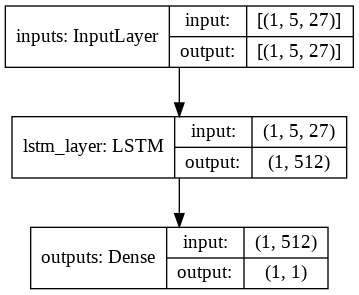

In [20]:
single_stock_lstm_graph = plot_model(single_stock_lstm, show_shapes=True, expand_nested=True)
single_stock_lstm_graph

In [0]:
single_stock_lstm.save(SINGLE_STOCK_LSTM_SAVE_PATH, save_format="h5")

### Training Single Stock Model


In [22]:
single_stock_lstm = load_model(SINGLE_STOCK_LSTM_SAVE_PATH)
single_stock_lstm_hist =pickle.load(open(SINGLE_STOCK_LSTM_HISTORY_PATH, "rb"))

In [0]:
steps_per_epoch=len(single_stock_prices_train)

In [0]:
single_stock_lstm.compile(optimizer=Adam(learning_rate=0.00001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])
# single_stock_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.BinaryAccuracy()])

In [0]:
# single_stock_lstm, single_stock_lstm_hist = training_stateful_rnn(single_stock_lstm, single_stock_train, init_epoch=0, epochs=100, steps_per_epoch=steps_per_epoch, val_data=single_stock_val)

In [30]:
single_stock_lstm, single_stock_lstm_hist = training_stateful_rnn(single_stock_lstm, single_stock_train, init_epoch=100, epochs=100, steps_per_epoch=steps_per_epoch, val_data=single_stock_val, history=single_stock_lstm_hist)

Train for 457 steps, validate for 5 steps
Epoch 101/101
457/457 [==============================] - 4s 8ms/step - loss: 1.4455e-04 - root_mean_squared_error: 0.0120 - val_loss: 7.3694e-05 - val_root_mean_squared_error: 0.0086
Train for 457 steps, validate for 5 steps
Epoch 102/102
457/457 [==============================] - 3s 6ms/step - loss: 7.3025e-05 - root_mean_squared_error: 0.0085 - val_loss: 8.0041e-05 - val_root_mean_squared_error: 0.0089
Train for 457 steps, validate for 5 steps
Epoch 103/103
457/457 [==============================] - 3s 6ms/step - loss: 6.1565e-05 - root_mean_squared_error: 0.0078 - val_loss: 6.5410e-05 - val_root_mean_squared_error: 0.0081
Train for 457 steps, validate for 5 steps
Epoch 104/104
457/457 [==============================] - 3s 6ms/step - loss: 5.3146e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.9346e-05 - val_root_mean_squared_error: 0.0070
Train for 457 steps, validate for 5 steps
Epoch 105/105
457/457 [==============================] - 3

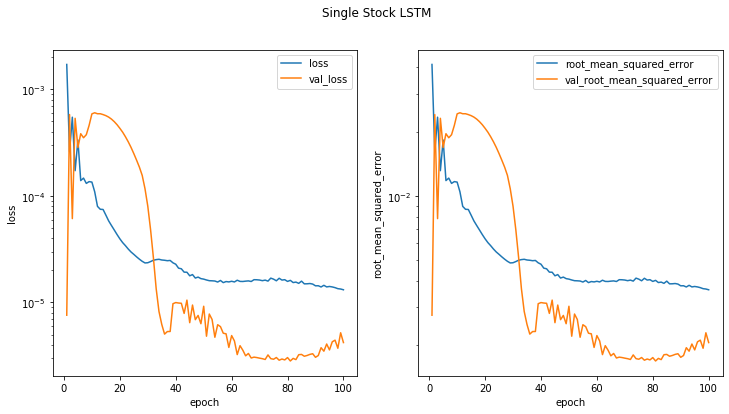

In [26]:
plot_model_history(single_stock_lstm_hist, fig_title="Single Stock LSTM", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
single_stock_lstm_metrics = calculate_model_metrics(single_stock_lstm, single_stock_lstm_hist, train_data=single_stock_train, train_targets=single_stock_targets_train, val_data=single_stock_val, val_targets=single_stock_targets_val, test_data=single_stock_test, test_targets=single_stock_targets_test, scaler=targets_scaler)

In [28]:
single_stock_lstm_metrics

,single_stock_lstm
train_epochs,100.00000
train_mse,0.00001
train_rmse,0.00363
train_inv_scale_rmse,34.68744
train_price_direct_accuracy,0.53947
val_mse,0.00000
val_rmse,0.00205
val_inv_scale_rmse,3.88872
val_price_direct_accuracy,1.00000
test_inv_scale_rmse,3.22002


In [0]:
single_stock_lstm.save(SINGLE_STOCK_LSTM_SAVE_PATH, save_format="h5")
pickle.dump(single_stock_lstm_hist, open(SINGLE_STOCK_LSTM_HISTORY_PATH, "wb"))
single_stock_lstm_metrics.to_csv(SINGLE_STOCK_LSTM_METRICS_PATH)

## Results

In [0]:
base_lstm_metrics = pd.read_csv(BASE_LSTM_001_METRICS_PATH, index_col=[0], header=[0])
stacked_lstm_metrics = pd.read_csv(STACKED_LSTM_METRICS_PATH, index_col=[0], header=[0])
single_stock_lstm_enc_metrics = pd.read_csv(SINGLE_STOCK_LSTM_ENC_METRICS_PATH, index_col=[0], header=[0])
single_stock_lstm_metrics = pd.read_csv(SINGLE_STOCK_LSTM_METRICS_PATH, index_col=[0], header=[0])
metrics = pd.concat([base_lstm_metrics, stacked_lstm_metrics, single_stock_lstm_enc_metrics, single_stock_lstm_metrics], axis=1)
metrics

,base_lstm_model,stacked_lstm,single_stock_lstm_enc,single_stock_lstm
train_epochs,300.00000,300.00000,300.00000,300.00000
train_mse,0.00000,0.00000,0.00008,0.00000
train_rmse,0.00187,0.00170,0.00892,0.00222
train_inv_scale_rmse,3.68804,3.50444,43.97110,16.61307
train_price_direct_accuracy,0.48720,0.51365,0.52193,0.53728
val_mse,0.00001,0.00000,0.00001,0.00001
val_rmse,0.00231,0.00194,0.00301,0.00229
val_inv_scale_rmse,4.50687,3.78100,5.74632,4.38643
val_price_direct_accuracy,0.44025,0.52772,0.00000,0.25000
test_inv_scale_rmse,4.50196,3.72403,11.49058,7.25799


In [0]:
base_lstm = load_model(BASE_LSTM_001_SAVE_PATH)
stacked_lstm = load_model(STACKED_LSTM_SAVE_PATH)
single_stock_lstm_enc = load_model(SINGLE_STOCK_LSTM_ENC_SAVE_PATH)
single_stock_lstm = load_model(SINGLE_STOCK_LSTM_SAVE_PATH)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))

In [0]:
train_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_train), index=single_stock_targets_train.index, columns=single_stock_targets_train.columns)
val_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_val), index=single_stock_targets_val.index, columns=single_stock_targets_val.columns)
test_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_test), index=single_stock_targets_test.index, columns=single_stock_targets_test.columns)
val_test_actual_prices = pd.concat([val_actual_prices, test_actual_prices])


all_stocks_val_test = stocks_val.concatenate(stocks_test)
all_stocks_val_test_index = pd.concat([stocks_prices_val, stocks_prices_test]).index

base_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(base_lstm.predict(all_stocks_val_test)), index=all_stocks_val_test_index, columns=["base_lstm_predictions"])
base_lstm_val_test_pred_prices = base_lstm_val_test_pred_prices[base_lstm_val_test_pred_prices.index.get_level_values(0) == stock_ticker]

stacked_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(stacked_lstm.predict(all_stocks_val_test)), index=all_stocks_val_test_index, columns=["stacked_lstm_predictions"])
stacked_lstm_val_test_pred_prices = stacked_lstm_val_test_pred_prices[stacked_lstm_val_test_pred_prices.index.get_level_values(0) == stock_ticker]


single_stock_val_test = single_stock_val.concatenate(single_stock_test)
single_stock_val_test_index = pd.concat([single_stock_prices_val, single_stock_prices_test]).index

single_stock_lstm_enc_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_lstm_enc.predict(single_stock_val_test)), index=single_stock_val_test_index, columns=["single_stock_lstm_enc_predictions"])
single_stock_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_lstm.predict(single_stock_val_test)), index=single_stock_val_test_index, columns=["single_stock_lstm_predictions"])


train_dates = list(train_actual_prices.index.get_level_values(1))
pred_dates = list(val_test_actual_prices.index.get_level_values(1))


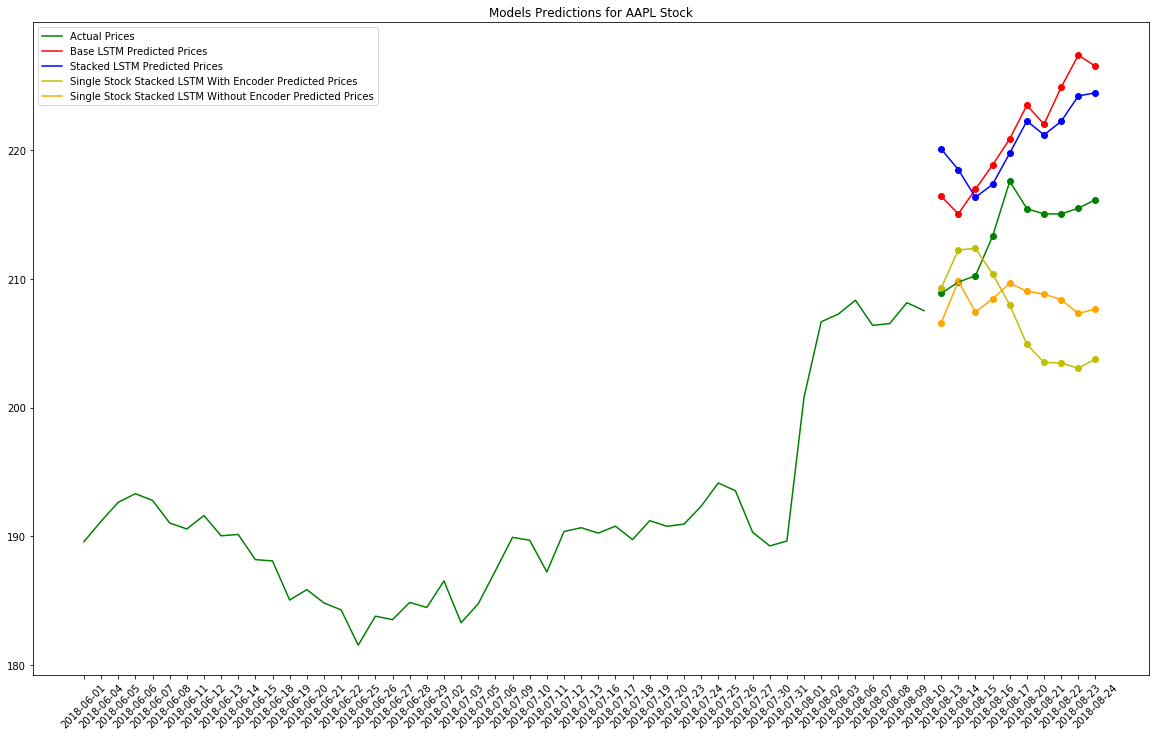

In [0]:
plt.figure(figsize=(20,12))
plt.gca().set_title("Models Predictions for {} Stock".format(stock_ticker))

plt.xticks(rotation=45)
plt.plot(train_dates[-50:], train_actual_prices.tail(50), c="g", label="Actual Prices")
plt.plot(pred_dates, val_test_actual_prices, c="g", )
plt.scatter(pred_dates, val_test_actual_prices, c="g")

plt.plot(pred_dates, base_lstm_val_test_pred_prices, c="r", label="Base LSTM Predicted Prices")
plt.scatter(pred_dates, base_lstm_val_test_pred_prices, c="r")

plt.plot(pred_dates, stacked_lstm_val_test_pred_prices, c="b", label="Stacked LSTM Predicted Prices")
plt.scatter(pred_dates, stacked_lstm_val_test_pred_prices, c="b")

plt.plot(pred_dates, single_stock_lstm_enc_val_test_pred_prices, c="y", label="Single Stock Stacked LSTM With Encoder Predicted Prices")
plt.scatter(pred_dates, single_stock_lstm_enc_val_test_pred_prices, c="y")

plt.plot(pred_dates, single_stock_lstm_val_test_pred_prices, c="orange", label="Single Stock Stacked LSTM Without Encoder Predicted Prices")
plt.scatter(pred_dates, single_stock_lstm_val_test_pred_prices, c="orange")

plt.legend()
plt.show()